# Описание проекта

**Заказчик**: каршеринговая компания (далее — Заказчик).

### **Цель:** 
Определить возможность предсказания ДТП, опираясь на исторические данные одного из регионов, с целью последующего создания системы оценки риска* ДТП на маршруте движения, выбранном клиентом Заказчика.  

_*Под риском в настоящем проекте принять **вероятность** ДТП с любым повреждением транспортного средства (далее — ТС). кроме царапин_  

---

### **Подцели:**

1. **Создание модели предсказания ДТП**  
   Целевое значение — `at_fault` (виновник) в таблице `parties`.  
   - Для моделирования использовать тип виновника — только машина (`car`).  
   - Выбрать случаи, когда ДТП привело к любым повреждениям ТС, кроме типа SCRATCH (царапина).  
   - Для моделирования ограничиться данными за 2012 год.  
   - Обязательное условие — учесть фактор возраста автомобиля.  

2. **На основе модели исследовать основные факторы ДТП.**

3. **Определение значимости результатов моделирования и анализа важности факторов** для следующих аспектов:  
   - Возможность создания адекватной системы оценки водительского риска при выдаче авто.  
   - Необходимость учёта дополнительных факторов.  
   - Необходимость дополнительного оборудования ТС датчиками и/или камерой.  


## План работы

### 1. **Загрузка данных из базы данных**

---

### 2. **Первичное исследование таблиц при помощи SQL-запроса**

Необходимо определить:  
- **a.** Все ли таблицы имеют набор данных;  
- **b.** Соответствует ли количество таблиц условию задачи;  
- **c.** Имеется ли общий ключ для связи таблиц.  

---

### 3. **Статистический анализ факторов ДТП**

#### 3.1. **Месяцы, в которые происходит наибольшее количество аварий**  
Анализ всего периода наблюдений (таблица `collisions`):  
- SQL-запрос;  
- График;  
- Вывод.  

#### 3.2. **Постановка аналитических задач коллегами**  

#### 3.3. **Решение для двух задач из списка**  

---

### 4. **Создание модели для оценки водительского риска**

#### 4.1. Подготовка набора данных на основе первичного предположения Заказчика  
- Подготовка исходной таблицы должна проводиться с помощью SQL-запроса.  

#### 4.2. Первичный отбор факторов для моделирования  

#### 4.3. Статистическое исследование отобранных факторов  
- По результату внести корректировки при необходимости.  
- Категоризация и масштабирование исходных данных.  
- Подготовка обучающей и тестовой выборок.  

---

### 5. **Определение оптимальной модели**

#### 5.1. Создание не менее 3-х типов моделей с перебором гиперпараметров  
#### 5.2. Выбор метрики для оценки модели исходя из поставленной задачи  
#### 5.3. Вывод в виде сравнительной таблицы  

---

### 6. **Проверка лучшей модели**

#### 6.1. Графический анализ с помощью матрицы ошибок  
#### 6.2. Анализ важности основных факторов, влияющих на вероятность ДТП  
#### 6.3. Дополнительное исследование для одного из важных факторов:  
- График зависимости фактора и целевой переменной;  
- Предложение, чем можно оборудовать автомобиль для учёта данного фактора во время посадки.  

---

### 7. **Общий вывод по модели**

- Описание лучшей модели.  
- Вывод о возможности создания системы оценки риска при выдаче авто.  
- Перечень дополнительных факторов для улучшения модели.  

# 0. Подготовка ноутбука к работе

**Импорты**

In [1]:
#pip install sqlalchemy -q

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from scipy.stats import ttest_ind

from sqlalchemy import create_engine, inspect 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 42

**Подключение к БД**

In [5]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [6]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string) 

**Функции**

In [7]:
# Function to display the main information about a data frame
def display_main_info(df):
    """
    Displays key information about the DataFrame for exploratory data analysis.
    
    Args:
        df (pandas.DataFrame): The DataFrame to be analyzed.
        
    Displays:
        - The first few rows of the DataFrame.
        - Data types and non-null counts of each column.
        - The shape (number of rows and columns) of the DataFrame.
        - The number of duplicate rows in the DataFrame.
        - The proportion of missing data for each column.
    """
    
    print('________________Head________________')
    display(df.head())
    
    print('________________Data Types Info________________')
    display(df.info())
    
    print('________________Shape________________')
    display(df.shape)
    
    print('________________Duplicates________________')
    display(df.duplicated().sum())
    
    print('________________Proportion of Missing Data________________')
    display(df.isna().mean())

In [8]:
def plot_histogram_and_boxplot(df, column):
    """
    Function to plot a histogram and a horizontal boxplot for a specified column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The name of the column for which the plots should be created.

    Returns:
    None: Displays the plots directly.
    """
    
    # Check if the column exists in the DataFrame
    if column not in df.columns:
        print(f"Column '{column}' not found in the DataFrame.")
        return
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the histogram with a custom color (green)
    sns.histplot(df[column], ax=axes[0], kde=False, bins=30, color='lightgreen')
    axes[0].set_title(f'Histogram for {column}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')
    
    # Plot the horizontal boxplot with a custom color (purple)
    sns.boxplot(x=df[column], ax=axes[1], orient='h', color='lightgreen')
    axes[1].set_title(f'Boxplot for {column}')
    axes[1].set_xlabel(column)
    
    # Display the plots
    plt.tight_layout()
    plt.show()

In [9]:
# Function that extracts numeric data from the dataset
def extract_numeric_data(df):
    numeric = df.select_dtypes(include='number').columns.tolist()
    return numeric


In [10]:
# Function that extracts non-numeric data from the dataset
def extract_categoric_data(df):
    categoric = df.select_dtypes(exclude='number').columns.tolist()
    return categoric

In [11]:
# Function to display statistical info
def show_stats(df, column_name):
    print(f'Statics for {column_name}')
    display(df[[column_name]].describe().T)

In [12]:
# Function to displays statistical info
def show_info_about_categories(df, column_name):
    print(f'___________Number of unique values for {column_name}:___________')
    display(df[column_name].nunique())
    
    print(f'___________Unique values for {column_name}:___________')
    display(df[column_name].value_counts(normalize=True))

In [13]:
def remove_rare_categories(df, column_name, threshold):
    """
    Replaces rare categories in a specified column with 'Other' based on a threshold.

    Parameters:
    - df: pandas DataFrame
    - column_name: str, name of the column to process
    - threshold: float, categories with frequency <= threshold will be replaced

    Returns:
    - Updated Series with replaced rare categories and their normalized value counts.
    """

    # Calculate normalized value counts
    category_counts = df[column_name].value_counts(normalize=True)
    
    # Identify rare categories
    rare_categories = category_counts[category_counts <= threshold].index
    
    # Replace rare categories with 'Other'
    df[column_name + '_new'] = df[column_name].apply(lambda x: 'Other' if x in rare_categories else x)
    
    # Return the normalized value counts of the new column
    return df[column_name + '_new'].value_counts(normalize=True)

# 1. Загрузка данных

In [14]:
# Функция для проверки наличия таблицы
def check_table_exists(engine, table_name):
    inspector = inspect(engine)
    return inspector.has_table(table_name)

# Проверка наличия таблиц
tables_to_check = ['collisions', 'vehicles', 'parties']
for table in tables_to_check:
    if check_table_exists(engine, table):
        print(f"Таблица '{table}' существует.")
    else:
        print(f"Таблица '{table}' не существует.")

Таблица 'collisions' существует.
Таблица 'vehicles' существует.
Таблица 'parties' существует.


In [15]:
# Import collisions from the Data Base

query_1 = '''
SELECT * FROM collisions
LIMIT 10
''' 
collisions = pd.read_sql_query(query_1, con = engine) 

In [16]:
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [17]:
# Import parties from the Data Base

query_2 = '''
SELECT * FROM parties
LIMIT 10
''' 
parties = pd.read_sql_query(query_2, con = engine) 

In [18]:
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [19]:
# Import vehicles from the Data Base

query_3 = '''
SELECT * FROM vehicles
LIMIT 10
''' 
vehicles = pd.read_sql_query(query_3, con = engine) 

In [20]:
vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


# 2. Первичное исследование

## 2.1. Таблица collisions (информация о происшествиях)

**Описание таблицы из ТЗ**

Имеет уникальный case_id. 

Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

| **Название поля**                               | **Код**                   | **Описание**                                                                                                 |
|-------------------------------------------------|---------------------------|-------------------------------------------------------------------------------------------------------------|
| Идентификационный Номер в базе данных           | CASE_ID                   | Уникальный номер для зарегистрированного происшествия в таблице происшествий.                               |
| Дата происшествия                               | COLLISION_DATE             | Формат год/месяц/день                                                                                         |
| Время происшествия                              | COLLISION_TIME             | Формат: 24-часовой                                                                                           |
| Является ли место происшествие перекрёстком      | INTERSECTION               | Y — Intersection (перекрёсток) <br> N — Not Intersection (не перекрёсток) <br> -- — Not stated (Не указано)   |
| Погода                                          | WEATHER_1                 | A — Clear (Ясно) <br> B — Cloudy (Облачно) <br> C — Raining (Дождь) <br> D — Snowing (Снегопад) <br> E — Fog (Туман) <br> F — Other (Другое) <br> G — Wind (Ветер) <br> - — Not Stated (Не указано) |
| Серьёзность происшествия                        | COLLISION_DAMAGE           | 1 — FATAL ТС (Не подлежит восстановлению) <br> 2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену) <br> 3 — MIDDLE DAMAGE (Средний ремонт) <br> 4 — SMALL DAMAGE (Отдельный элемент кузова под замену) <br> 0 – SCRATCH (Царапина) |
| Основной фактор аварии                          | PRIMARY_COLL_FACTOR        | A — Code Violation (Нарушение правил ПДД) <br> B — Other Improper Driving (Другое неправильное вождение) <br> C — Other Than Driver (Кроме водителя) <br> D — Unknown (Неизвестно) <br> E — Fell Asleep (Заснул) <br> - — Not Stated (Не указано) |
| Состояние дороги                                | ROAD_SURFACE               | A — Dry (Сухая) <br> B — Wet (Мокрая) <br> C — Snowy or Icy (Заснеженная или обледенелая) <br> D — Slippery (Скользкая) <br> - — Not Stated (Не указано) |
| Освещение                                      | LIGHTING                   | A — Daylight (Дневной свет) <br> B — Dusk-Dawn (Сумерки-Рассвет) <br> C — Dark-Street Lights (Темно-Уличные фонари) <br> D — Dark-No Street Lights (Темно-Нет уличных фонарей) <br> E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают) <br> - — Not Stated (Не указано) |
| Номер географических районов, где произошло ДТП  | COUNTY_CITY_LOCATION       | Число                                                                                                       |
| Названия географических районов, где произошло ДТП | COUNTY_LOCATION            | Список разных названий, категориальный тип данных                                                             |
| Направление движения                           | DIRECTION                  | N — North (Север) <br> E — East (Восток) <br> S — South (Юг) <br> W — West (Запад) <br> - or blank — Not State (Не указано) |
| Расстояние от главной дороги (метры)            | DISTANCE                   | Число                                                                                                       |
| Тип дороги                                     | LOCATION_TYPE              | H — Highway (Шоссе) <br> I — Intersection (Перекрёсток) <br> R — Ramp (or Collector) (Рампа) <br> - or blank — Not State Highway (Не указано) |
| Количество участников                          | PARTY_COUNT                | Число                                                                                                       |
| Категория нарушения                            | PCF_VIOLATION_CATEGORY     | 01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения) <br> 02 — Impeding Traffic (Препятствие движению транспорта) <br> 03 — Unsafe Speed (Превышение скорости) <br> 04 — Following Too Closely (Опасное сближение) <br> 05 — Wrong Side of Road (Неправильная сторона дороги) <br> 06 — Improper Passing (Неправильное движение) <br> 07 — Unsafe Lane Change (Небезопасная смена полосы движения) <br> 08 — Improper Turning (Неправильный поворот) <br> 09 — Automobile Right of Way (Автомобильное право проезда) <br> 10 — Pedestrian Right of Way (Пешеходное право проезда) <br> 11 — Pedestrian Violation (Нарушение пешеходами) <br> 12 — Traffic Signals and Signs (Дорожные сигналы и знаки) <br> 13 — Hazardous Parking (Неправильная парковка) <br> 14 — Lights (Освещение) <br> 15 — Brakes (Тормоза) <br> 16 — Other Equipment (Другое оборудование) <br> 17 — Other Hazardous Violation (Другие нарушения) <br> 18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода) <br> 19 — Speeding (Скорость) <br> 20 — Pedestrian dui (Нарушение пешехода) <br> 21 — Unsafe Starting or Backing (Опасный старт) <br> 22 — Other Improper Driving (Другое неправильное вождение) <br> 23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения) <br> 24 — Fell Asleep (Заснул) <br> 00 — Unknown (Неизвестно) <br> - — Not Stated (Не указано) |
| Тип аварии                                     | TYPE_OF_COLLISION          | A — Head-On (Лоб в лоб) <br> B — Sideswipe (Сторона) <br> C — Rear End (Столкновение задней частью) <br> D — Broadside (Боковой удар) <br> E — Hit Object (Удар объекта) <br> F — Overturned (Опрокинутый) <br> G — Vehicle (транспортное средство/ Пешеход) <br> H — Other (Другое) <br> - — Not Stated (Не указано) |
| Дополнительные участники ДТП                    | MOTOR_VEHICLE_INVOLVED_WITH | Other motor vehicle (Другой автомобиль) <br> Fixed object (Неподвижный объект) <br> Parked motor vehicle (Припаркованный автомобиль) <br> Pedestrian (Пешеход) <br> Bicycle (Велосипедист) <br> Non-collision (Не столкновение) <br> Other object (Другой объект) <br> Motor vehicle on other roadway (Автомобиль на другой проезжей) <br> Animal (Животное) <br> Train (Поезд) |
| Дорожное состояние                             | ROAD_CONDITION_1           | A — Holes, Deep Ruts (Ямы, глубокая колея) <br> B — Loose Material on Roadway (Сыпучий материал на проезжей части) <br> C — Obstruction on Roadway (Препятствие на проезжей части) <br> D — Construction or Repair Zone (Зона строительства или ремонта) <br> E — Reduced Roadway Width (Уменьшенная ширина проезжей части) <br> F — Flooded (Затоплено) <br> G — Other (Другое) <br> H — No Unusual Condition (Нет ничего необычного) <br> - — Not Stated (Не указано) |
| Устройство управления                          | CONTROL_CONDITION_1        | A — Functioning (Функционирует) <br> B — Not Functioning (Не функционирует) <br> C — Obscured (Затемнённый) <br> D — None (Нет) <br> - — Not Stated (Не указано) |


In [21]:
display_main_info(collisions)

________________Head________________


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      10 non-null     object 
 1   county_city_location         10 non-null     object 
 2   county_location              10 non-null     object 
 3   distance                     10 non-null     float64
 4   direction                    4 non-null      object 
 5   intersection                 10 non-null     int64  
 6   weather_1                    10 non-null     object 
 7   location_type                5 non-null      object 
 8   collision_damage             10 non-null     object 
 9   party_count                  10 non-null     int64  
 10  primary_collision_factor     10 non-null     object 
 11  pcf_violation_category       9 non-null      object 
 12  type_of_collision            10 n

None

________________Shape________________


(10, 20)

________________Duplicates________________


0

________________Proportion of Missing Data________________


case_id                        0.0
county_city_location           0.0
county_location                0.0
distance                       0.0
direction                      0.6
intersection                   0.0
weather_1                      0.0
location_type                  0.5
collision_damage               0.0
party_count                    0.0
primary_collision_factor       0.0
pcf_violation_category         0.1
type_of_collision              0.0
motor_vehicle_involved_with    0.0
road_surface                   0.0
road_condition_1               0.1
lighting                       0.0
control_device                 0.0
collision_date                 0.0
collision_time                 0.0
dtype: float64

## 2.2. Таблица parties (описание участников происшествия)

**Описание таблицы из ТЗ**

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. 

Каждая строка здесь описывает одну из сторон, участвующих в ДТП. 

Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. 

Если нужен уникальный идентификатор, это case_id and party_number.

| **Название поля**                               | **Код**                   | **Описание**                                                                                                 |
|-------------------------------------------------|---------------------------|-------------------------------------------------------------------------------------------------------------|
| Идентификационный номер в базе данных           | CASE_ID                   | Уникальный номер для зарегистрированного происшествия в таблице происшествий.                               |
| Номер участника происшествия                    | PARTY_NUMBER              | От 1 до N — по числу участников происшествия.                                                               |
| Тип участника происшествия                      | PARTY_TYPE                | 1 — Car (Авто) <br> 2 — Road bumper (Отбойник) <br> 3 — Building (Строение) <br> 4 — Road signs (Дорожные знаки) <br> 5 — Other (Другое) <br> 6 — Operator (Оператор) <br> - — Not Stated (Не указано) |
| Виновность участника                            | AT_FAULT                  | 0/1                                                                                                         |
| Сумма страховки (тыс. $)                        | INSURANCE_PREMIUM         | Число                                                                                                       |
| Состояние участника: физическое или с учётом принятых лекарств | PARTY_DRUG_PHYSICAL        | E — Under Drug Influence (Под воздействием лекарств) <br> F — Impairment — Physical (Ухудшение состояния) <br> G — Impairment Unknown (Неизвестно) <br> H — Not Applicable (Не оценивался) <br> I — Sleepy/Fatigued (Сонный/Усталый) <br> - — Not Stated (Не указано) |
| Трезвость участника                              | PARTY_SOBRIETY            | A — Had Not Been Drinking (Не пил) <br> B — Had Been Drinking, Under Influence (Был пьян, под влиянием) <br> C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием) <br> D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно) <br> G — Impairment Unknown (Неизвестно ухудшение) <br> H — Not Applicable (Не оценивался) <br> - — Not Stated (Не указано) |
| Наличие телефона в автомобиле (возможности разговаривать по громкой связи) | CELLPHONE_IN_USE           | 0/1                                                                                                         |


In [22]:
display_main_info(parties)

________________Head________________


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10 non-null     int64  
 1   case_id              10 non-null     object 
 2   party_number         10 non-null     int64  
 3   party_type           10 non-null     object 
 4   at_fault             10 non-null     int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       10 non-null     object 
 7   party_drug_physical  4 non-null      object 
 8   cellphone_in_use     9 non-null      float64
dtypes: float64(2), int64(3), object(4)
memory usage: 852.0+ bytes


None

________________Shape________________


(10, 9)

________________Duplicates________________


0

________________Proportion of Missing Data________________


id                     0.0
case_id                0.0
party_number           0.0
party_type             0.0
at_fault               0.0
insurance_premium      0.6
party_sobriety         0.0
party_drug_physical    0.6
cellphone_in_use       0.1
dtype: float64

## 2.3. Таблица vehicles (Описание автомобиля)

**Описание таблицы из ТЗ**

Информация о пострадавших машинах.

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. 

Если нужен уникальный идентификатор, это case_id and party_number.

| **Описание**                                | **Обозначение в таблице** | **Подробнее**                                                                                              |
|---------------------------------------------|---------------------------|------------------------------------------------------------------------------------------------------------|
| Индекс текущей таблицы                      | ID                        | Номер в таблице                                                                                           |
| Идентификационный номер в базе данных       | CASE_ID                   | Уникальный номер для зарегистрированного происшествия в таблице происшествий.                             |
| Тип кузова                                  | VEHICLE_TYPE              | MINIVAN <br> COUPE <br> SEDAN <br> HATCHBACK <br> OTHER                                                   |
| Тип КПП                                     | VEHICLE_TRANSMISSION      | auto — Автоматическая <br> manual — Ручная <br> - — Not Stated (Не указано)                               |
| Возраст автомобиля (в годах)                | VEHICLE_AGE               | Число                                                                                                     |


In [23]:
display_main_info(vehicles)

________________Head________________


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    10 non-null     int64 
 1   case_id               10 non-null     object
 2   party_number          10 non-null     int64 
 3   vehicle_type          10 non-null     object
 4   vehicle_transmission  10 non-null     object
 5   vehicle_age           10 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


None

________________Shape________________


(10, 6)

________________Duplicates________________


0

________________Proportion of Missing Data________________


id                      0.0
case_id                 0.0
party_number            0.0
vehicle_type            0.0
vehicle_transmission    0.0
vehicle_age             0.0
dtype: float64

## **Выводы:**
- Количество таблиц соответствует условию задачи.  
- Однако, не везде таблицы в точности соответствуют описанию из ТЗ. Будет необходимо дополнительное исследование признаков при моделировании.
- Все три таблицы имеют наборы данных, соответствующие описанию из ТЗ. 
- Имеется общий ключ для связи таблиц - `case_id`.  

# 3. Статистический анализ факторов ДТП

## 3.1. Месяцы, в которые происходит наибольшее количество аварий

Анализ всего периода наблюдений (таблица `collisions`)

In [24]:
query_4 = '''
SELECT 
    EXTRACT(MONTH FROM COLLISION_DATE) AS month,
    COUNT(*) AS total_collisions
FROM 
    collisions
GROUP BY 
    month
ORDER BY 
    total_collisions DESC
''' 
coll_month = pd.read_sql_query(query_4, con = engine) 

In [25]:
coll_month

,month,total_collisions
0,3.0,139581
1,1.0,132044
2,5.0,130316
3,4.0,130180
4,2.0,128858
5,10.0,112237
6,12.0,107945
7,9.0,105159
8,11.0,104770
9,8.0,104089


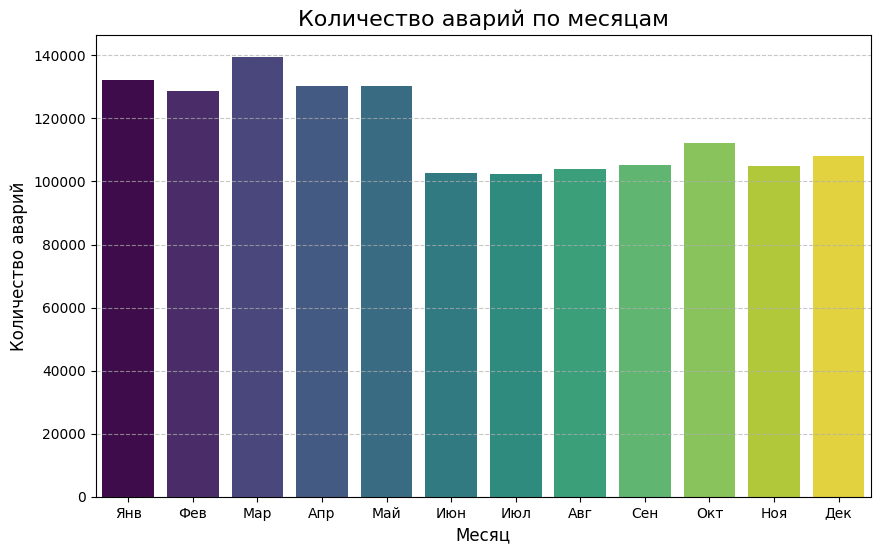

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total_collisions', hue='month', data=coll_month, palette='viridis', legend=False)

plt.title('Количество аварий по месяцам', fontsize=16)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество аварий', fontsize=12)
plt.xticks(ticks=range(0, 12), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

**Выводы:**

- **Сезонность аварийности:** Данные показывают четкую сезонную зависимость. Зимние и весенние месяцы характеризуются повышенной аварийностью, что может быть связано с неблагоприятными погодными условиями (снег, гололед, дождь). Летние месяцы, напротив, являются наиболее безопасными.

- **Самый аварийный месяц:** Март лидирует по количеству аварий, что может быть связано с переходом от зимних условий к весенним (таяние снега, гололедица).

- **Летний минимум:** Июль и июнь — месяцы с наименьшим количеством аварий, что подтверждает влияние благоприятных погодных условий на безопасность дорожного движения.

## 3.2 Перечень пналитических задач для анализа ДТП

1. **Определить, какие типы кузова (`VEHICLE_TYPE`) автомобилей чаще всего участвуют в ДТП с фатальным исходом (`COLLISION_DAMAGE = 1`).**  
   *(Связь таблиц `vehicles` и `collisions` по `CASE_ID`).*

2. **Проанализировать, влияет ли возраст автомобиля (`VEHICLE_AGE`) на вероятность серьезных повреждений (`COLLISION_DAMAGE = 2 или 3`).**  
   *(Связь таблиц `vehicles` и `collisions` по `CASE_ID`).*

3. **Выявить, есть ли связь между физическим состоянием водителя (`PARTY_DRUG_PHYSICAL`) и виновностью (`AT_FAULT`).**  
   *(Связь таблиц `parties` и `collisions` по `CASE_ID`).*

4. **Определить, какие категории нарушений (`PCF_VIOLATION_CATEGORY`) наиболее часто встречаются среди водителей, попавших в ДТП при плохих погодных условиях (`WEATHER_1 != 'A'`).**  
   *(Связь таблиц `collisions` и `parties` по `CASE_ID`).*

5. **Анализ зависимости между типом передачи автомобиля (`VEHICLE_TRANSMISSION`) и частотой аварий по вине водителя (`AT_FAULT = 1`).**  
   *(Связь таблиц `vehicles` и `parties` по `CASE_ID`).*

6. **Определить, увеличивается ли риск ДТП при наличии неисправных элементов автомобиля (`PCF_VIOLATION_CATEGORY = 15 или 16`), и какие именно поломки встречаются чаще.**  
   *(Связь таблиц `collisions` и `vehicles` по `CASE_ID`).*

## 3.3 Решение для первых двух задач из перечня

### 3.3.1. Задача 1. Взаимосвязь между типом кузова и ДТП с фатальным исходом.

**Цель:** Определить, какие типы кузова (`VEHICLE_TYPE`) чаще всего участвуют в ДТП с фатальным исходом (`COLLISION_DAMAGE` = 'fatal').

**Шаги выполнения:**

- Объединить таблицы `vehicles` и `collisions` по `CASE_ID`.
- Отфильтровать случаи с фатальным исходом (`COLLISION_DAMAGE` = 'fatal').
- Посчитать количество аварий для каждого типа кузова (`VEHICLE_TYPE`).
- Построить график для наглядности.

In [27]:
query_5 = '''
SELECT 
    v.VEHICLE_TYPE, 
    COUNT(*) AS fatal_accidents
FROM 
    vehicles v
JOIN 
    collisions c 
ON
    v.CASE_ID = c.CASE_ID
WHERE
    c.COLLISION_DAMAGE = 'fatal'
GROUP BY
    v.VEHICLE_TYPE
ORDER BY
    fatal_accidents DESC
'''

In [28]:
vehicles_fatal = pd.read_sql_query(query_5, con = engine) 

In [29]:
vehicles_fatal

,vehicle_type,fatal_accidents
0,coupe,8916
1,sedan,2892
2,hatchback,2786
3,minivan,527
4,other,22


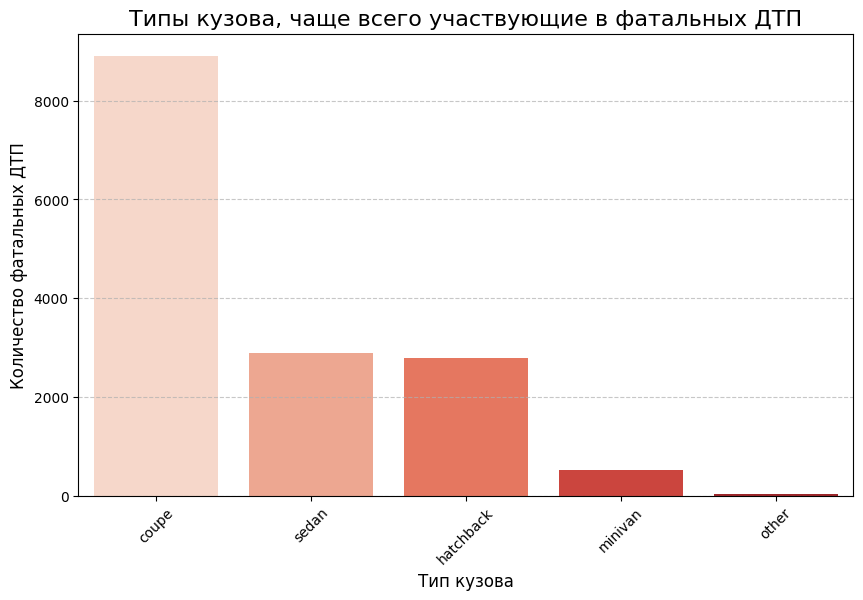

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x="vehicle_type", y="fatal_accidents", hue="vehicle_type", data=vehicles_fatal, palette="Reds", legend=False)

plt.title("Типы кузова, чаще всего участвующие в фатальных ДТП", fontsize=16)
plt.xlabel("Тип кузова", fontsize=12)
plt.ylabel("Количество фатальных ДТП", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

**Выводы:**

- **Наибольшее количество фатальных ДТП** зафиксировано среди автомобилей типа `coupe` (**8916 случаев**).  
  Это значительно превышает показатели других типов кузова. Возможно, это связано с тем, что купе  
  чаще используются для динамичной езды, могут иметь более мощные двигатели и привлекают водителей,  
  склонных к агрессивному стилю вождения.

- **Автомобили `sedan` (2892 случая) и `hatchback` (2786 случаев)** занимают второе и третье место  
  по количеству смертельных аварий. Их показатели сопоставимы и, вероятно, отражают их широкое распространение на дорогах.

- **Автомобили `minivan` (527 случаев)** реже попадают в фатальные аварии. Это может быть связано  
  с более спокойным стилем вождения владельцев минивэнов, которые чаще используют их для семейных поездок.

- **Категория `other` (22 случая)** имеет наименьшее количество смертельных ДТП. В эту группу  
  могут входить редкие или специализированные транспортные средства, что объясняет столь низкое число аварий.


### 3.3.2. Задача 2. Взаимосвязь между физическим состоянием водителя и виновностью в ДТП.

**Цель:** Выявить, есть ли связь между физическим состоянием водителя (`PARTY_DRUG_PHYSICAL`) и виновностью (`AT_FAULT`).

**Шаги выполнения:**

1. Объединить таблицы `parties` и `collisions` по `CASE_ID`.
2. Cруппировать по состоянию водителя (`PARTY_DRUG_PHYSICAL`) и виновности (`AT_FAULT`).
3. Посчитать количество случаев для каждой группы.
5. Сравнить доли виновных по каждой категории.

In [31]:
query_6 = '''
SELECT 
    p.PARTY_DRUG_PHYSICAL, 
    p.AT_FAULT, 
    COUNT(*) AS count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percent_total
FROM parties p
JOIN collisions c ON p.CASE_ID = c.CASE_ID
GROUP BY p.PARTY_DRUG_PHYSICAL, p.AT_FAULT
ORDER BY p.PARTY_DRUG_PHYSICAL
'''

In [32]:
conditions = pd.read_sql_query(query_6, con = engine) 

In [33]:
conditions

,party_drug_physical,at_fault,count,percent_total
0,G,0,50177,1.82
1,G,1,182724,6.64
2,impairment - physical,0,2314,0.08
3,impairment - physical,1,1874,0.07
4,not applicable,0,156542,5.69
5,not applicable,1,12801,0.47
6,sleepy/fatigued,0,575,0.02
7,sleepy/fatigued,1,12066,0.44
8,under drug influence,0,1054,0.04
9,under drug influence,1,12161,0.44


**Выводы:**

**Большинство водителей не имеют зафиксированных нарушений, связанных с физическим состоянием**  
- **84,3%** случаев (сумма категорий `None`) приходится на водителей без признаков воздействия наркотиков, усталости или физических нарушений.  
- Среди них **45,55%** не были виновниками ДТП, а **38,75%** признаны виновными.  

**Категория `G` (Impairment Unknown) имеет высокий процент виновности**  
- В **6,64%** случаев водители с этим статусом были признаны виновниками аварий.  
- Это самый высокий процент среди специфических состояний.  

**Водители в состоянии наркотического опьянения (`under drug influence`) чаще оказываются виновниками**  
- **0,44%** всех аварий связано с виновниками под воздействием наркотиков.  
- Доля невиновных водителей в этой группе значительно ниже (**0,04%**), что указывает на сильное влияние наркотиков на вероятность ДТП.  

**Усталость (`sleepy/fatigued`) также увеличивает вероятность виновности**  
- **0,44%** всех ДТП произошло по вине уставших или заснувших за рулём водителей.  
- Лишь **0,02%** случаев этой группы пришлось на невиновных участников.  

**Физические нарушения (`impairment - physical`) оказывают меньшее влияние**  
- Доля виновных и невиновных практически одинакова (**0,07%** и **0,08%** соответственно).  

**Общий вывод**  
Наибольший риск быть признанным виновником ДТП наблюдается среди водителей, находившихся под влиянием наркотиков или испытывавших усталость. Категория `G` также показывает высокую степень виновности, но её точное значение неясно. 
Большинство участников ДТП не имеют зафиксированных физических или химических факторов, что указывает на важность общего водительского поведения, а не только физиологического состояния.

# 4. Создание модели для оценки водительского риска

## 4.1. Подготовка набора данных на основе первичного предположения Заказчика  

### Первичный отбор признаков
По условию задачи в качестве таргета необходимо принять признак `at_fault` из таблицы `parties`. Это бинарный признак, который показывает, виновен ли участник в ДТП. Таким образом, мы будем предсказывать вероятность того, что клиент Заказчика станет виновником ДТП при совокупности определённых факторов.

#### Для начала отберём признаки из таблицы `parties`:

`id`:
Не понадобится. Это технический идентификатор, не несущий полезной информации для модели.

`case_id`:
Необходим для объединения таблиц. Сам по себе не используется в модели.

`party_number`:
Не подходит, так как не может быть исходной информацией при выборе маршрута. 

`party_type`:
Сам по себе не нужен, но по условию заказчика фильтруем по нему - берём только тип `car` (автомобиль).

`at_fault`:
Необходим, так как является таргетом.

`insurance_premium`:
Подходит, так как сумма страховки может косвенно указывать на стоимость автомобиля, что, в свою очередь, может влиять на его безопасность.

`party_sobriety`:
Трезвость непосредственно влияет на способность управлять транспортным средством. Однако, такая информация известна уже по происшествии ДТП. Даже в случае дооборудования каршерингового ТС алко-тестером, это не постоянный фактор, т.к. водитель может употребить спиртное уже после того, как модель сделала прогноз и было начато движение.

`party_drug_physical`:
Аналогично признаку `party_sobriety`. В дополнение, как выявлено ранее большая часть данных (более 80%) не содержит информации по типу состояния водителя. Не может быть использован для моделирования.

`cellphone_in_use`:
Не подходит. Использование телефона за рулём увеличивает риск ДТП, но при выборе маршрута это система определить не сможет.

#### Таблица `collisions`

`case_id`: Необходим только для объединения таблиц.

`county_city_location`: Возможно, подходит, так как вероятность ДТП необходимо спрогнозировать на определённом маршруте. Соответственно, геоданные могут быть полезны. Однако, данный категориальный признак имеет большое количество уникальных значений (538). Необходимо доп.исследование.

`county_location`: Возможно, подходит - геоданные.

`distance`: Возможно, подходит - геоданные. 

`direction`: Возможно, подходит - геоданные.

`intersection`: Возможно, подходит - геоданные. 

`weather_1`: Не буду использовать, т.к. погода не постоянна. Даже при наличии датчика погоды, она может кардинально измениться уже через 5 минут после начала движения.

`location_type`: Подходит, геоданные - разные типы дорог (шоссе, перекрёстки, рампы) имеют разный уровень риска ДТП.  

`collision_damage`: Сам по себе признак не нужен, так как нет цели строить модель классификации по типу повреждения. Однако, необходимо при отборе других признаков учесть, что по требованию заказчика тип `SCRATCH` не подходит.  

`party_count`: Не подходит, так как не известно до наступления ДТП.

`primary_collision_factor`: Не подходит, так как не известно до наступления ДТП.  

`pcf_violation_category`: Не подходит, так как не известно до наступления ДТП.

`type_of_collision`: Не подходит, так как не известно до наступления ДТП. 

`motor_vehicle_involved_with`: Не подходит, так как не известно до наступления ДТП.  

`road_surface`: Возможно, подходит, так как тип дороги на маршруте следования — важный фактор. Однако, необходимо, чтобы при использовании продукта тип покрытия на выбранном маршруте был известен системе.   

`road_condition_1`: Возможно, подходит. Однако, необходимо, чтобы при использовании продукта тип дороги на выбранном маршруте был известен системе.  

`lighting`: Не подходит, так как это освещение непосредственно на месте ДТП. При использовании продукта не будет возможности заранее спрогнозировать освещение на всём маршруте следования.  

`control_device`: Не подходит, так как состояние светофоров и пр. не известно до наступления ДТП. 

`collision_date`: Подходит, так как можно выделить день недели и месяц ДТП (Необходимо учесть, что необходим только 2012 год).  

`collision_time`: Подходит, так как можно выделить время суток, что влияет на вероятность ДТП.  

#### Таблица `vehicles`

`id` - Не подходит, т.к. техническая информация.

`case_id` - Необходим для связки таблиц.

`party_number` - Не подходит, так как не может быть исходной информацией при выборе маршрута.  

`vehicle_type` - Подходит. Тип ТС может влиять на вероятность ДТП.

`vehicle_transmission` - Подходит. Тип КПП может косвенно влиять на вероятность ДТП.

`vehicle_age` - подходит, возраст может косвенно влиять на риск ДТП.

In [34]:
query_7 = '''
SELECT
    p.at_fault,

    c.county_city_location,
    c.county_location,
    c.distance,
    c.direction,
    c.intersection,
    c.location_type,
    c.road_surface,
    c.road_condition_1,
    c.collision_date, 
    c.collision_time,
    
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age
FROM 
    parties p
JOIN
    collisions c
ON
    p.case_id = c.case_id
JOIN
    vehicles v
ON
    p.case_id = v.case_id AND p.party_number = v.party_number
WHERE 
    LOWER(p.party_type) = 'car' 
    AND LOWER(c.collision_damage) = 'scratch'
    AND EXTRACT(YEAR FROM c.collision_date) = 2012 
    AND v.vehicle_age IS NOT NULL
'''

## 4.2. Получение признаков

In [35]:
df_preliminary = pd.read_sql_query(query_7, con = engine, parse_dates=['collision_date']) 

In [36]:
display_main_info(df_preliminary)

________________Head________________


,at_fault,county_city_location,county_location,distance,direction,intersection,location_type,road_surface,road_condition_1,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
0,0,1000,fresno,1584.0,west,0.0,None,dry,normal,2012-02-04,15:10:00,coupe,manual,8
1,1,3607,san bernardino,528.0,west,0.0,highway,dry,normal,2012-01-13,15:55:00,coupe,auto,7
2,1,3450,sacramento,150.0,west,0.0,None,dry,normal,2012-01-03,13:42:00,sedan,manual,1
3,1,1502,kern,45.0,north,0.0,highway,dry,normal,2012-01-06,09:48:00,coupe,auto,4
4,0,3404,sacramento,0.0,None,1.0,None,dry,normal,2012-01-10,21:50:00,coupe,auto,3


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46052 entries, 0 to 46051
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   at_fault              46052 non-null  int64         
 1   county_city_location  46052 non-null  object        
 2   county_location       46052 non-null  object        
 3   distance              46052 non-null  float64       
 4   direction             31982 non-null  object        
 5   intersection          45887 non-null  float64       
 6   location_type         17244 non-null  object        
 7   road_surface          45626 non-null  object        
 8   road_condition_1      45762 non-null  object        
 9   collision_date        46052 non-null  datetime64[ns]
 10  collision_time        46031 non-null  object        
 11  vehicle_type          46052 non-null  object        
 12  vehicle_transmission  4515

None

________________Shape________________


(46052, 14)

________________Duplicates________________


120

________________Proportion of Missing Data________________


at_fault                0.000000
county_city_location    0.000000
county_location         0.000000
distance                0.000000
direction               0.305524
intersection            0.003583
location_type           0.625554
road_surface            0.009250
road_condition_1        0.006297
collision_date          0.000000
collision_time          0.000456
vehicle_type            0.000000
vehicle_transmission    0.019413
vehicle_age             0.000000
dtype: float64

- Будем рассматривать данный датасет как полученный от заказчика. Сразу отделим из него 20% на отложенную тестовую выборку.

In [37]:
df_main, df_test = train_test_split(df_preliminary, test_size=0.2, random_state=RANDOM_STATE) # Сразу отделяем 20%

- Можно отметить, что location_type имеет более 50% пропусков. Использовать данный признак не целесообразно. 

- Пропуски в категориальных признаках (`direction`, `intersection`, `road_surface`, `road_condition_1`, `vehicle_transmission`) - заполним на этапе моделирования на 'Unknown'.

In [38]:
df_main = df_main.drop(columns=['location_type'])

df_test= df_test.drop(columns=['location_type'])

## 4.3. EDA признаков

### 4.3.1 Таргет

In [39]:
show_info_about_categories(df_main, 'at_fault')

___________Number of unique values for at_fault:___________


2

___________Unique values for at_fault:___________


at_fault
0    0.62102
1    0.37898
Name: proportion, dtype: float64

Есть дисбаланс классов. Попробуем учесть это при моделировании.

### 4.2.1 Численные

In [40]:
df_main.head()

,at_fault,county_city_location,county_location,distance,direction,intersection,road_surface,road_condition_1,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
7422,1,3310,riverside,428.0,east,0.0,wet,reduced width,2012-01-24,07:58:00,coupe,manual,3
33869,1,0700,contra costa,2130.0,south,0.0,dry,normal,2012-04-19,09:11:00,coupe,auto,5
4396,1,3496,sacramento,18.0,north,0.0,dry,normal,2012-01-06,11:00:00,sedan,manual,0
2156,1,1900,los angeles,3600.0,south,0.0,dry,normal,2012-01-30,07:55:00,coupe,manual,4
39669,1,1954,los angeles,100.0,east,0.0,dry,normal,2012-03-29,20:45:00,coupe,auto,6


In [41]:
df_main_numeric = ['distance', 'vehicle_age']

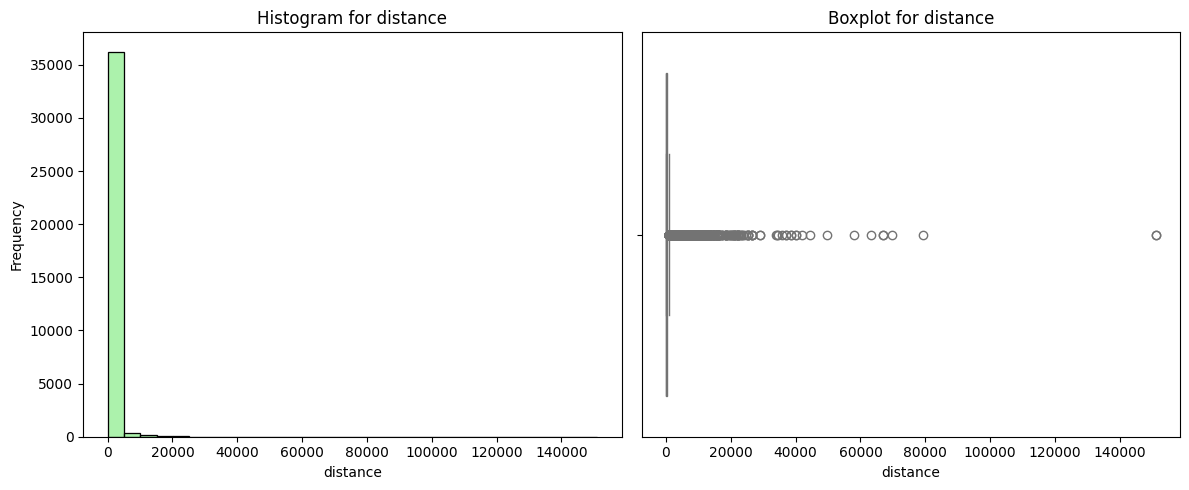

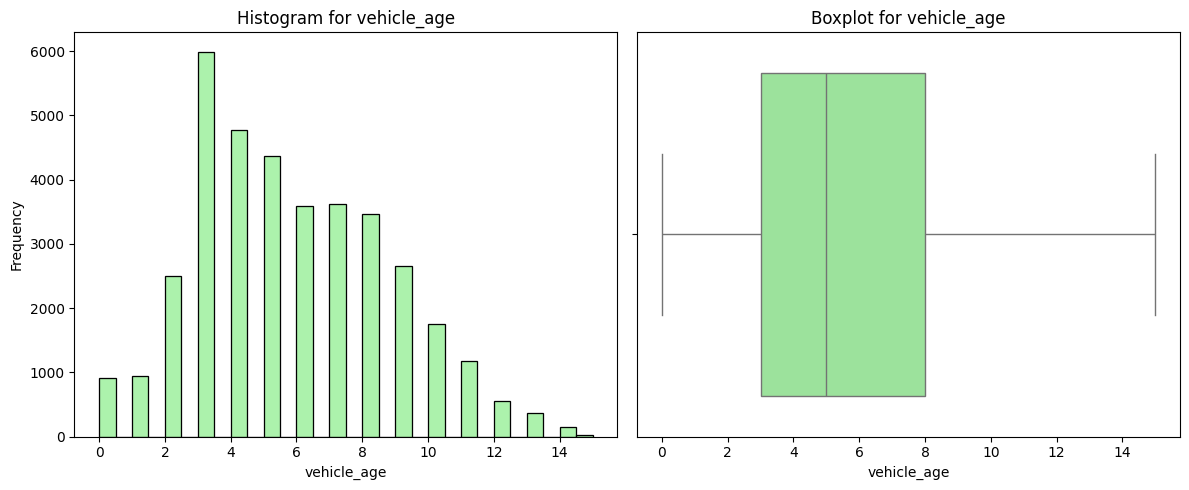

In [42]:
for col in df_main[df_main_numeric]:
    plot_histogram_and_boxplot(df_main, col)

In [43]:
for col in df_main[df_main_numeric]:
    show_stats(df_main, col)

Statics for distance


,count,mean,std,min,25%,50%,75%,max
distance,36841.0,510.509762,2130.239036,0.0,0.0,74.0,395.0,151008.0


Statics for vehicle_age


,count,mean,std,min,25%,50%,75%,max
vehicle_age,36841.0,5.637496,2.93511,0.0,3.0,5.0,8.0,15.0


**Наблюдения:**

- `distance` - есть одно сильно выбивающееся значения. Я удалю эту строку.

- Также, я применю лог-трансформацию, чтобы сгладить получившиеся распределения.

In [44]:
_q1 = df_main['distance'] < 151008.0

df_main = df_main[_q1]

Лог-трансформация

In [45]:
def apply_log_transform(df, num_cols):
    for col in df[num_cols]:
        df[col] = df[col].replace(0, 1)
        df[col + '_log'] = np.log(df[col])

In [46]:
# Основного датасета
apply_log_transform(df_main, num_cols=df_main_numeric)

# Также, для отделённой тестовой выборки
apply_log_transform(df_test, num_cols=df_main_numeric)

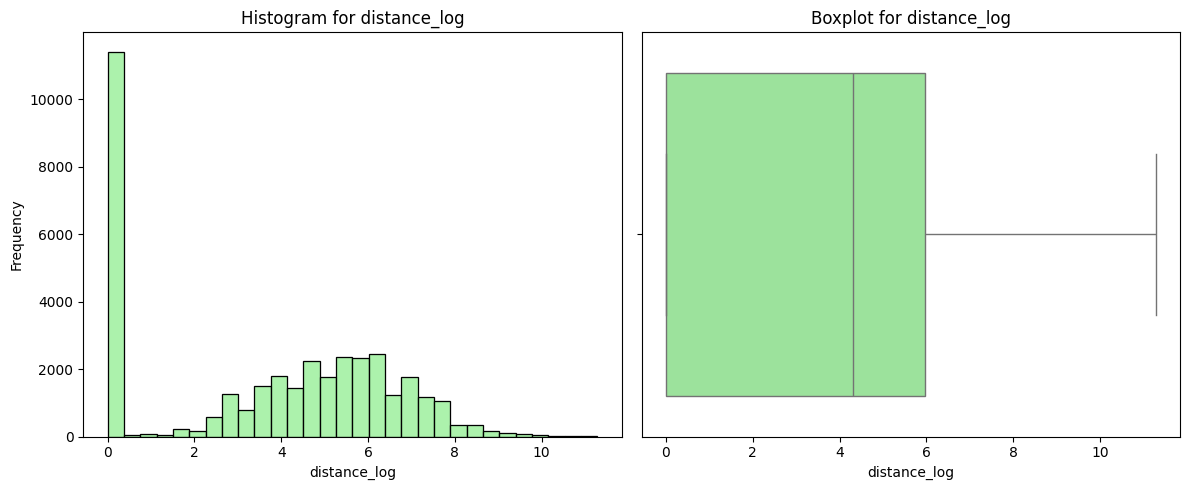

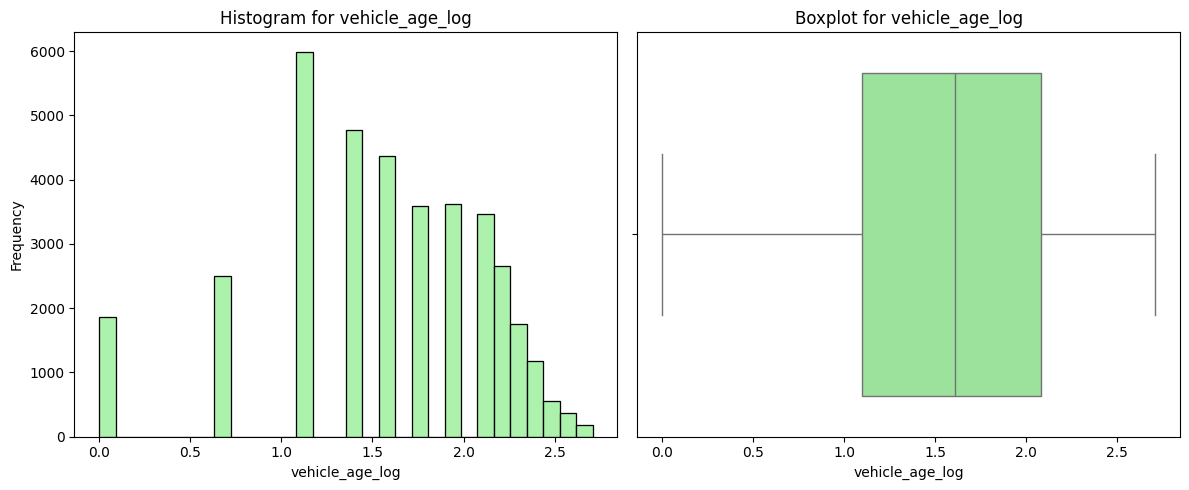

In [47]:
df_log = ['distance_log', 'vehicle_age_log']

for col in df_log:
    plot_histogram_and_boxplot(df_main, col)

Статистический анализ

In [48]:
df_main.groupby('at_fault')[df_log].describe().T

at_fault                          0             1
distance_log    count  22878.000000  13961.000000
                mean       3.530652      3.866196
                std        2.735603      2.895575
                min        0.000000      0.000000
                25%        0.000000      0.000000
                50%        4.094345      4.605170
                75%        5.736572      6.214608
                max       11.056588     11.279732
vehicle_age_log count  22878.000000  13961.000000
                mean       1.637246      1.478971
                std        0.576561      0.632455
                min        0.000000      0.000000
                25%        1.386294      1.098612
                50%        1.791759      1.386294
                75%        2.079442      1.945910
                max        2.708050      2.708050

In [49]:
df_main.groupby('at_fault')[df_main_numeric].describe().T


at_fault                      0             1
distance    count  22878.000000  13961.000000
            mean     383.184797    698.414036
            std     1220.842740   2495.056702
            min        1.000000      1.000000
            25%        1.000000      1.000000
            50%       60.000000    100.000000
            75%      310.000000    500.000000
            max    63360.000000  79200.000000
vehicle_age count  22878.000000  13961.000000
            mean       5.908252      5.258506
            std        2.777214      3.026271
            min        1.000000      1.000000
            25%        4.000000      3.000000
            50%        6.000000      4.000000
            75%        8.000000      7.000000
            max       15.000000     15.000000

**Наблюдения:**
- Видно, что средние по дистанции отличаются (для невиновных среднее ниже).
- По возрасту авто средние близки, проверим т-тестом.

**Проверка влияния distance на таргет методом Т-тест**

- Нулевая гипотеза (H0): средние distance  у виновников и не виновников равны.
- Альтернативная гипотеза (Н1): средний distance у не виновников ниже.

In [50]:
group_1 = df_main[df_main['at_fault'] == 0]['distance'].dropna()
group_2 = df_main[df_main['at_fault'] == 1]['distance'].dropna()

results = ttest_ind(group_1, group_2, alternative='less')

print(f"P-значение: {results.pvalue}") 

if results.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу в пользу альтернативной.")
else:
    print("Нет оснований отвергать нулевую гипотезу.")

P-значение: 4.357640935383543e-59
Отвергаем нулевую гипотезу в пользу альтернативной.


**Проверка влияния vehicle_age на таргет методом Т-тест**

- Нулевая гипотеза (H0): средние vehicle_age  у виновников и не виновников равны.
- Альтернативная гипотеза (Н1): средний vehicle_age у виновников ниже.

In [51]:
group_1 = df_main[df_main['at_fault'] == 1]['vehicle_age'].dropna()
group_2 = df_main[df_main['at_fault'] == 0]['vehicle_age'].dropna()

results = ttest_ind(group_1, group_2, alternative='less')

print(f"P-значение: {results.pvalue}") 

if results.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу в пользу альтернативной.")
else:
    print("Нет оснований отвергать нулевую гипотезу.")

P-значение: 4.324741633485444e-98
Отвергаем нулевую гипотезу в пользу альтернативной.


Исходя из статистического исследования, различия в дистанции и в возрасте ТС являются статистически значимыми для двух групп участников движения. 

Проверим также при помощи feature_importance.

### 4.2.2 Категориальные

Отделение месяца и дня недели

In [52]:
def extract_day_month_name(df, col):
    df['day_of_week'] = df[col].dt.day_name()
    df['month_name'] = df[col].dt.month_name()

In [53]:
# Основная 
extract_day_month_name(df_main, 'collision_date')

# Тестовая
extract_day_month_name(df_test, 'collision_date')

Время суток

In [54]:
def extract_part_of_day(df, col):
    # Преобразуем столбец в datetime и извлекаем время
    df[col] = pd.to_datetime(df[col], format='%H:%M:%S', errors='coerce').dt.time

    df.dropna(subset=[col], inplace=True)

    morning_start = datetime.time(6, 0)
    afternoon_start = datetime.time(12, 0)
    evening_start = datetime.time(18, 0)
    night_start = datetime.time(22, 0)

    def part_of_day(time):
        if time is None:  
            return None
        if morning_start <= time < afternoon_start:
            return 'Morning'
        elif afternoon_start <= time < evening_start:
            return 'Afternoon'
        elif evening_start <= time < night_start:
            return 'Evening'
        else:
            return 'Night'

    df['part_of_day'] = df[col].apply(part_of_day)

In [55]:
# Основной
extract_part_of_day(df_main, 'collision_time')

# Тестовый
extract_part_of_day(df_test, 'collision_time')

In [56]:
df_main_cat = [ 
    'county_city_location', 
    'county_location', 
    'direction', 
    'intersection', 
    'road_surface', 
    'road_condition_1', 
    'vehicle_type', 
    'vehicle_transmission',
    'month_name', 
    'day_of_week', 
    'part_of_day']

In [57]:
for col in df_main_cat:
    show_info_about_categories(df_main, col)

___________Number of unique values for county_city_location:___________


473

___________Unique values for county_city_location:___________


county_city_location
1942    0.164960
3711    0.038321
1900    0.025393
4313    0.022514
3400    0.017571
          ...   
5003    0.000027
2403    0.000027
4112    0.000027
4709    0.000027
0401    0.000027
Name: proportion, Length: 473, dtype: float64

___________Number of unique values for county_location:___________


58

___________Unique values for county_location:___________


county_location
los angeles        0.331686
orange             0.097227
san diego          0.083566
riverside          0.049591
san bernardino     0.048912
sacramento         0.043236
santa clara        0.039733
alameda            0.037805
ventura            0.024090
kern               0.021129
contra costa       0.020586
san mateo          0.017897
san joaquin        0.014421
fresno             0.013769
stanislaus         0.013226
sonoma             0.013118
santa barbara      0.011325
solano             0.010836
san francisco      0.010755
placer             0.009750
tulare             0.008799
monterey           0.007197
santa cruz         0.006328
marin              0.006192
napa               0.005405
merced             0.005214
butte              0.004726
san luis obispo    0.004698
madera             0.003612
yolo               0.003395
el dorado          0.003205
humboldt           0.003178
imperial           0.003015
kings              0.002960
shasta             0.002553
sutt

___________Number of unique values for direction:___________


4

___________Unique values for direction:___________


direction
north    0.274166
south    0.271743
east     0.229488
west     0.224602
Name: proportion, dtype: float64

___________Number of unique values for intersection:___________


2

___________Unique values for intersection:___________


intersection
0.0    0.707199
1.0    0.292801
Name: proportion, dtype: float64

___________Number of unique values for road_surface:___________


4

___________Unique values for road_surface:___________


road_surface
dry         0.894305
wet         0.101637
snowy       0.003509
slippery    0.000548
Name: proportion, dtype: float64

___________Number of unique values for road_condition_1:___________


8

___________Unique values for road_condition_1:___________


road_condition_1
normal            0.971380
construction      0.015226
holes             0.005850
obstruction       0.002898
other             0.002296
loose material    0.001039
reduced width     0.000656
flooded           0.000656
Name: proportion, dtype: float64

___________Number of unique values for vehicle_type:___________


3

___________Unique values for vehicle_type:___________


vehicle_type
coupe    0.691589
sedan    0.308058
other    0.000353
Name: proportion, dtype: float64

___________Number of unique values for vehicle_transmission:___________


2

___________Unique values for vehicle_transmission:___________


vehicle_transmission
auto      0.570131
manual    0.429869
Name: proportion, dtype: float64

___________Number of unique values for month_name:___________


12

___________Unique values for month_name:___________


month_name
March        0.217512
January      0.209799
February     0.201570
April        0.189783
May          0.159447
June         0.016838
August       0.001928
September    0.001657
July         0.000760
October      0.000489
December     0.000136
November     0.000081
Name: proportion, dtype: float64

___________Number of unique values for day_of_week:___________


7

___________Unique values for day_of_week:___________


day_of_week
Friday       0.168708
Tuesday      0.156650
Wednesday    0.154205
Thursday     0.148774
Monday       0.137612
Saturday     0.129356
Sunday       0.104696
Name: proportion, dtype: float64

___________Number of unique values for part_of_day:___________


4

___________Unique values for part_of_day:___________


part_of_day
Afternoon    0.450477
Morning      0.288640
Evening      0.172157
Night        0.088727
Name: proportion, dtype: float64

Схлопнем некоторые категории.

`county_city_location`

In [58]:
remove_rare_categories(df_main, 'county_city_location', threshold=0.01)

county_city_location_new
Other    0.639716
1942     0.164960
3711     0.038321
1900     0.025393
4313     0.022514
3400     0.017571
3404     0.016268
3001     0.016214
3700     0.013145
0109     0.012221
3019     0.011597
1500     0.011325
3801     0.010755
Name: proportion, dtype: float64

In [59]:
remove_rare_categories(df_test, 'county_city_location', threshold=0.01)

county_city_location_new
Other    0.644114
1942     0.161707
3711     0.033341
1900     0.029648
4313     0.021286
3400     0.017919
3404     0.017485
3001     0.015096
3019     0.014987
3313     0.011512
3801     0.011512
0109     0.010860
3700     0.010534
Name: proportion, dtype: float64

`county_location`

In [60]:
remove_rare_categories(df_main, 'county_location', threshold=0.01)

county_location_new
los angeles       0.331686
orange            0.097227
Other             0.097091
san diego         0.083566
riverside         0.049591
san bernardino    0.048912
sacramento        0.043236
santa clara       0.039733
alameda           0.037805
ventura           0.024090
kern              0.021129
contra costa      0.020586
san mateo         0.017897
san joaquin       0.014421
fresno            0.013769
stanislaus        0.013226
sonoma            0.013118
santa barbara     0.011325
solano            0.010836
san francisco     0.010755
Name: proportion, dtype: float64

In [61]:
remove_rare_categories(df_test, 'county_location', threshold=0.01)

county_location_new
los angeles       0.331777
orange            0.102302
Other             0.099262
san diego         0.077107
riverside         0.051151
san bernardino    0.048002
sacramento        0.044526
santa clara       0.038771
alameda           0.036056
ventura           0.024109
contra costa      0.020960
kern              0.019005
san mateo         0.016833
sonoma            0.015096
stanislaus        0.014227
fresno            0.014010
san joaquin       0.013684
san francisco     0.011512
santa barbara     0.011512
solano            0.010100
Name: proportion, dtype: float64

Многие признаки имеют весьма большое число категорий. Определить значимость будет возможно только с моделью, которая хорошо работает с high-cardinality категориальными признаками (например, CatBoost, LightGBM).

In [62]:
display_main_info(df_main)

________________Head________________


,at_fault,county_city_location,county_location,distance,direction,intersection,road_surface,road_condition_1,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age,distance_log,vehicle_age_log,day_of_week,month_name,part_of_day,county_city_location_new,county_location_new
7422,1,3310,riverside,428.0,east,0.0,wet,reduced width,2012-01-24,07:58:00,coupe,manual,3,6.059123,1.098612,Tuesday,January,Morning,Other,riverside
33869,1,0700,contra costa,2130.0,south,0.0,dry,normal,2012-04-19,09:11:00,coupe,auto,5,7.663877,1.609438,Thursday,April,Morning,Other,contra costa
4396,1,3496,sacramento,18.0,north,0.0,dry,normal,2012-01-06,11:00:00,sedan,manual,1,2.890372,0.000000,Friday,January,Morning,Other,sacramento
2156,1,1900,los angeles,3600.0,south,0.0,dry,normal,2012-01-30,07:55:00,coupe,manual,4,8.188689,1.386294,Monday,January,Morning,1900,los angeles
39669,1,1954,los angeles,100.0,east,0.0,dry,normal,2012-03-29,20:45:00,coupe,auto,6,4.605170,1.791759,Thursday,March,Evening,Other,los angeles


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
Index: 36821 entries, 7422 to 15795
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   at_fault                  36821 non-null  int64         
 1   county_city_location      36821 non-null  object        
 2   county_location           36821 non-null  object        
 3   distance                  36821 non-null  float64       
 4   direction                 25583 non-null  object        
 5   intersection              36687 non-null  float64       
 6   road_surface              36473 non-null  object        
 7   road_condition_1          36583 non-null  object        
 8   collision_date            36821 non-null  datetime64[ns]
 9   collision_time            36821 non-null  object        
 10  vehicle_type              36821 non-null  object        
 11  vehicle_transmission      36104 no

None

________________Shape________________


(36821, 20)

________________Duplicates________________


81

________________Proportion of Missing Data________________


at_fault                    0.000000
county_city_location        0.000000
county_location             0.000000
distance                    0.000000
direction                   0.305206
intersection                0.003639
road_surface                0.009451
road_condition_1            0.006464
collision_date              0.000000
collision_time              0.000000
vehicle_type                0.000000
vehicle_transmission        0.019473
vehicle_age                 0.000000
distance_log                0.000000
vehicle_age_log             0.000000
day_of_week                 0.000000
month_name                  0.000000
part_of_day                 0.000000
county_city_location_new    0.000000
county_location_new         0.000000
dtype: float64

# 5. Моделирование

## 5.1  Выбор метрики

**Метрика**

В такой задаче важно, чтобы метрика улавливала ошибки второго рода, т.е. False Negative, т.к. ошибки второго рода критичны (лучше ошибиться в сторону обвинения, чем пропустить виновного). 

В данном случае я выбираю в качестве метрики **Recall**. Пропуск реального виновника будет иметь серьёзные последствия (например, в судебных разбирательствах, страховых выплатах и т. д.).

## 5.2 Модель 1 - Random Forest Classifier

In [63]:
cols_to_keep = [
    'at_fault',  
    'direction', 
    'road_surface', 
    'road_condition_1',
    'vehicle_type',
    'vehicle_transmission',
    'distance_log',
    'vehicle_age_log',
    'day_of_week', 
    'month_name', 
    'part_of_day',
    'county_city_location_new', 
    'county_location_new'
]

In [64]:
df_rf = df_main[cols_to_keep]

target = 'at_fault'

features = df_rf.drop(target, axis=1)

numeric = features.select_dtypes(exclude='object').columns.to_list()
categorical = features.select_dtypes(include='object').columns.to_list()

X_train = features
y_train = df_rf[target]

In [65]:
# ======== Categorical transformer with imputation ========
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical)
    ],
    remainder='passthrough'
)

# ======== Pipeline with preprocessing and model ========
accidents_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', RandomForestClassifier(random_state=RANDOM_STATE))
])

# ======== Params for Search ========
param_grid = [
    {
        'estimator': [RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'estimator__n_estimators': [50, 100, 200, 300],
        'estimator__max_depth': range(3, 20, 2),
        'estimator__min_samples_split': range(2, 15, 2),
        'estimator__min_samples_leaf': range(1, 10, 2),
        'estimator__max_features': ['sqrt', 'log2', None],
        'estimator__bootstrap': [True, False]
    }
]

In [66]:
%%time
search_rf = RandomizedSearchCV(
    estimator = accidents_pipe,
    param_distributions = param_grid,
    n_iter=6,
    scoring='recall',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

CPU times: user 18 µs, sys: 1 µs, total: 19 µs
Wall time: 25.7 µs


In [67]:
%%time
search_rf.fit(X_train, y_train)

CPU times: user 6.3 s, sys: 414 ms, total: 6.71 s
Wall time: 43.7 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='unknown',
                                                                                                              strategy='constant')),
                                                                                               ('encoder',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan))]),
                                                                               ['direction',
                                                                                'road_surface',
                                                                                'road_condition_1',
                                                                                'vehicl...
                   param_distributions=[{'estimator': [RandomForestClassifier(class_weight='balanced',
                                                                              random_state=42)],
                                         'estimator__bootstrap': [True, False],
                                         'estimator__max_depth': range(3, 20, 2),
                                         'estimator__max_features': ['sqrt',
                                                                     'log2',
                                                                     None],
                                         'estimator__min_samples_leaf': range(1, 10, 2),
                                         'estimator__min_samples_split': range(2, 15, 2),
                                         'estimator__n_estimators': [50, 100,
                                                                     200,
                                                                     300]}],
                   random_state=42, scoring='recall')

In [68]:
print("Best parameters:", search_rf.best_params_)
print("Best recall", search_rf.best_score_)

Best parameters: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 3, 'estimator__max_features': 'log2', 'estimator__max_depth': 9, 'estimator__bootstrap': False, 'estimator': RandomForestClassifier(class_weight='balanced', random_state=42)}
Best recall 0.5200341342949496


In [69]:
# Output the params 
res = pd.DataFrame(search_rf.cv_results_).sort_values(by='mean_test_score', ascending=False).head(1)
res_rf= res[['mean_fit_time', 'mean_score_time', 'mean_test_score']].copy()
res_rf

,mean_fit_time,mean_score_time,mean_test_score
3,7.270996,0.213436,0.520034


## 5.3 Модель 2 - LGBM

In [70]:
df_lgbm = df_main[cols_to_keep]

target = 'at_fault'
features = df_lgbm.drop(target, axis=1)

numeric = features.select_dtypes(exclude='object').columns.to_list()
categorical = features.select_dtypes(include='object').columns.to_list()

In [71]:
for cat in categorical:
    df_lgbm[cat] = df_lgbm[cat].astype('category')

In [72]:
X_train = df_lgbm.drop(target, axis=1)
y_train = df_lgbm[target]

In [73]:
estimator = LGBMClassifier(is_unbalance=True, random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [-1, 5, 10, 15],  
    'num_leaves': [31, 50, 100],  
    'min_child_samples': [10, 20, 30],  
    'subsample': [0.7, 0.8, 0.9, 1.0],  
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

In [74]:
%%time
search_lgbm = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,
    n_iter=5,
    scoring='recall',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 17.9 µs


In [75]:
%%time
search_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 11161, number of negative: 18296[LightGBM] [Info] Number of positive: 11160, number of negative: 18296

[LightGBM] [Info] Number of positive: 11161, number of negative: 18296
[LightGBM] [Info] Number of positive: 11160, number of negative: 18296
[LightGBM] [Info] Number of positive: 11161, number of negative: 18296
[LightGBM] [Info] Number of positive: 11161, number of negative: 18296
[LightGBM] [Info] Number of positive: 11161, number of negative: 18296
[LightGBM] [Info] Number of positive: 11161, number of negative: 18296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 29456, number of used features: 12
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(is_unbalance=True, random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 5, 10, 15],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [31, 50, 100],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='recall')

In [76]:
print("Best parameters:", search_lgbm.best_params_)
print("Best Recall", search_lgbm.best_score_)

Best parameters: {'subsample': 0.7, 'num_leaves': 100, 'n_estimators': 300, 'min_child_samples': 30, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best Recall 0.5028302698509932


In [77]:
# Output the params 
res = pd.DataFrame(search_lgbm.cv_results_).sort_values(by='mean_test_score', ascending=False).head(1)
res_lgbm= res[['mean_fit_time', 'mean_score_time', 'mean_test_score']].copy()
res_lgbm

,mean_fit_time,mean_score_time,mean_test_score
0,10.992318,0.104344,0.50283


## 5.4 Модель 3 - CatBoostClassifier

In [78]:
df_cb = df_main[cols_to_keep]


target = 'at_fault'
features = df_cb.drop(target, axis=1)

numeric = features.select_dtypes(exclude='object').columns.to_list()
categorical = features.select_dtypes(include='object').columns.to_list()

X_train = features
y_train = df_cb[target]

X_train = X_train.fillna("missing_value")

model = CatBoostClassifier(auto_class_weights='Balanced', random_state=RANDOM_STATE, verbose=0)

param_distributions = {
    'iterations': [100, 300, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

random_search = RandomizedSearchCV(
    model,
    param_distributions,
    n_iter=5,
    scoring='recall',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search.fit(X_train, y_train, cat_features=categorical)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x14774f4d0>,
                   n_iter=5, n_jobs=-1,
                   param_distributions={'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [100, 300, 500, 1000],
                                        'l2_leaf_reg': [1, 3, 5, 7],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.2]},
                   random_state=42, scoring='recall')

In [79]:
print("Best Parameters:", random_search.best_params_)
print("Best Recall Score:", random_search.best_score_)

Best Parameters: {'learning_rate': 0.2, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 6, 'border_count': 32}
Best Recall Score: 0.5623968233787815


In [80]:
# Output the params 
res = pd.DataFrame(random_search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(1)
res_cb= res[['mean_fit_time', 'mean_score_time', 'mean_test_score']].copy()
res_cb

,mean_fit_time,mean_score_time,mean_test_score
4,4.66228,0.049319,0.562397


## 5.5 Сравнение и выбор лучшей модели

In [82]:
# Compare the performance of each of the models
compare = pd.concat([res_rf, res_lgbm, res_cb])
compare.index = ['RandomForest', 'LGBM', 'CatBoost']
compare

,mean_fit_time,mean_score_time,mean_test_score
RandomForest,7.270996,0.213436,0.520034
LGBM,10.992318,0.104344,0.502830
CatBoost,4.662280,0.049319,0.562397


**Выводы:**
- Метрика не высокая на всех трёх моделях.
- Однако, CatBoost имеет явное преимущество. Попробуем изменить порог и улучшить Recall, используя модель CatBoost.

# 6 Лучшая модель. Корректировка порога.

Попробуем изменить порог в CatBoost. Возможно, получится вытянуть метрику.

In [88]:
# Подготовка данных
df_cb = df_main[cols_to_keep]
target = 'at_fault'
features = df_cb.drop(target, axis=1)

numeric = features.select_dtypes(exclude='object').columns.to_list()
categorical = features.select_dtypes(include='object').columns.to_list()

X_train = features
y_train = df_cb[target]

X_train[numeric] = X_train[numeric].fillna(0)
X_train[categorical] = X_train[categorical].fillna("missing_value")

# Модель с лучшими параметрами
best_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.2,
    l2_leaf_reg=3,
    border_count=32,
    auto_class_weights='Balanced',
    random_state=RANDOM_STATE,
    verbose=0,
    cat_features=categorical
)

# Получаем предсказанные вероятности с помощью cross_val_predict
y_proba = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba', n_jobs=-1)[:, 1]


threshold = 0.38
y_pred = (y_proba >= threshold).astype(int)


recall = recall_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_proba) 

print(f"Threshold: {threshold}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"ROC-AUC: {roc_auc}")

Threshold: 0.38
Recall: 0.8557809476023224
Precision: 0.41936843584249534
ROC-AUC: 0.6481666108097688


Удалось максимизировать Recall.

## 6.2 Проверка модели на тестовой выборке. Матрица ошибок.

In [169]:
test = df_test[cols_to_keep]

target = 'at_fault'
features = test.drop(target, axis=1)

numeric = features.select_dtypes(exclude='object').columns.to_list()
categorical = features.select_dtypes(include='object').columns.to_list()

X_test = features
y_test = test[target]

X_test = X_test.fillna("missing_value")
y_test = y_test.fillna("missing_value")

Test Recall: 0.8579266531908749
Test Precision: 0.4175685172171469
Test ROC-AUC: 0.6540049424195455
Test Confusion Matrix:
[[1600 4144]
 [ 492 2971]]


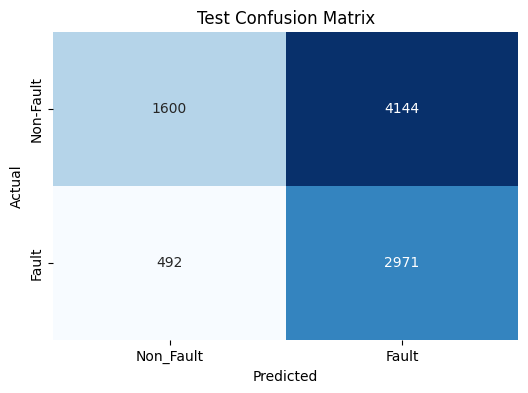

In [170]:
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)

# качество на тестовой выборке
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)
test_cm = confusion_matrix(y_test, y_test_pred)

print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test ROC-AUC: {test_roc_auc}")
print("Test Confusion Matrix:")
print(test_cm)

# Визуализация confusion matrix для тестовой выборки
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non_Fault", "Fault"],
            yticklabels=["Non-Fault", "Fault"])
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

В принципе, при кастомном пороге (threshold = 0.3)  возможно добиться следующих результатов:

**Recall** = 0.86 — что модель правильно классифицировала 84% всех положительных примеров. Это высокий показатель, указывающий на хорошую способность модели выявлять положительный класс, что критично в контексте данной задачи.

**ROC-AUC** = 0.65 — модель имеет умеренное качество в различении классов, с областью под кривой около 0.64. Это значение ниже идеала (1.0), но всё же свидетельствует о том, что модель может отличить положительный класс от отрицательного.


Однако, стоит обратить внимание Заказчика, что при таком пороге показатель **Precision = 0.42**, что говорит о том, что из всех предсказанных положительных примеров, только **42%** на самом деле оказались положительными. Это означает, что модель делает довольно много ложных срабатываний.

## 6.3 Важность признаков

                     Feature  Importance
6            vehicle_age_log   33.669381
5               distance_log   15.975842
9                part_of_day   14.071370
11       county_location_new    8.233382
3               vehicle_type    7.154927
7                day_of_week    5.150668
1               road_surface    4.494898
4       vehicle_transmission    4.301554
10  county_city_location_new    3.218911
0                  direction    2.829890
8                 month_name    0.485207
2           road_condition_1    0.413972


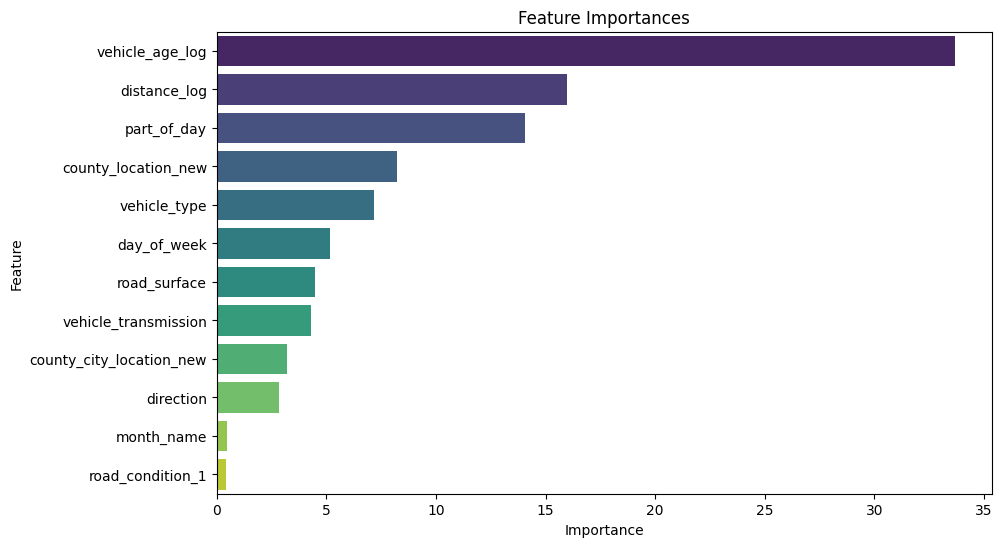

In [171]:
# Получите важность признаков
feature_importances = best_model.get_feature_importance()

# Создайте DataFrame для удобного отображения
import pandas as pd

feature_names = X_train.columns  # Имена признаков
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Отсортируем по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выведем таблицу
print(importance_df)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Наблюдения:**
- Похоже, что количественные признаки важнее всех категориальных. 
- Самый главный по важности признак, это возраст авто.
- Среди категориальных можно отметить важность времени суток, местоположение и тип ТС.

In [172]:
df_main.groupby('at_fault')[['vehicle_age']].mean()

,vehicle_age
at_fault,
0,5.908067
1,5.274328


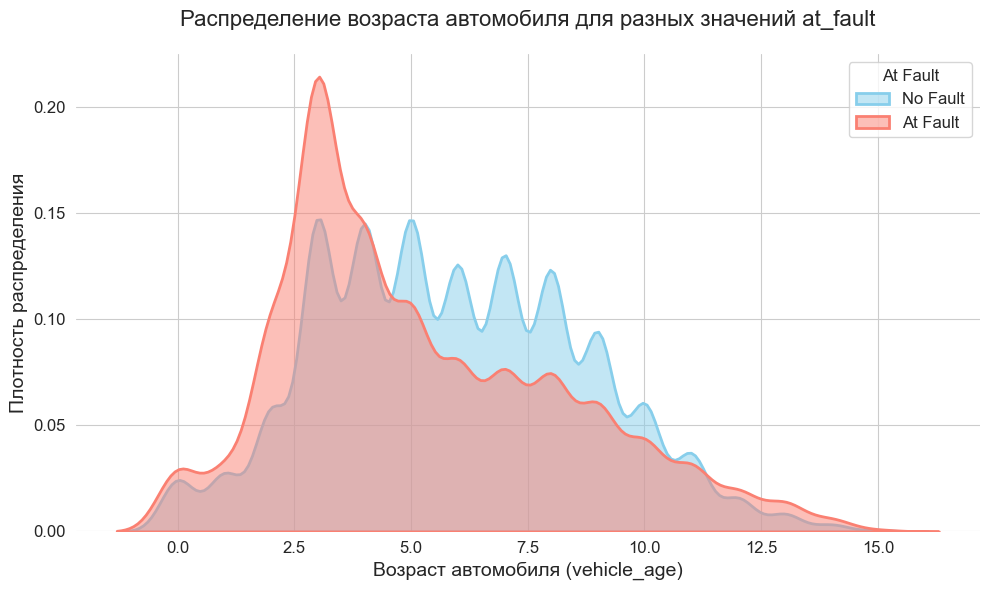

In [173]:
sns.set_style("whitegrid") 
plt.figure(figsize=(10, 6))  

sns.kdeplot(
    df_preliminary[df_preliminary['at_fault'] == 0]['vehicle_age'],
    label='No Fault',
    fill=True,
    color='skyblue',  
    alpha=0.5,  
    linewidth=2  
)

sns.kdeplot(
    df_preliminary[df_preliminary['at_fault'] == 1]['vehicle_age'],
    label='At Fault',
    fill=True,
    color='salmon',  
    alpha=0.5,  
    linewidth=2 


plt.title('Распределение возраста автомобиля для разных значений at_fault', fontsize=16, pad=20)
plt.xlabel('Возраст автомобиля (vehicle_age)', fontsize=14)
plt.ylabel('Плотность распределения', fontsize=14)


plt.legend(title='At Fault', title_fontsize=12, fontsize=12, loc='upper right')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


sns.despine(left=True, bottom=True)

plt.tight_layout() 
plt.show()

In [174]:
df_test['predictions'] = y_test_proba

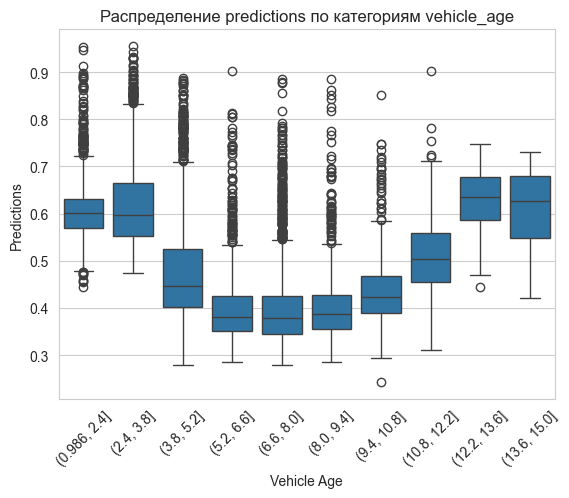

In [175]:
age_bins = pd.cut(df_test['vehicle_age'], bins=10)
sns.boxplot(x=age_bins, y=df_test['predictions'])

plt.title('Распределение predictions по категориям vehicle_age')
plt.xlabel('Vehicle Age')
plt.ylabel('Predictions')
plt.xticks(rotation=45)
plt.show()

**Наблюдения:**
Похоже, что "группа риска" - авто возраста от 10 до 15 лет. 
Однако, интересно, что относительно "молодые" авто, также имеют более высокую вероятность стать виновниками аварии. Оптимальный диапазон по мнению модели - 3.8 - 10 лет.

# 7. Общий вывод по модели

**Итоговая модель**

CatBoostClassifier c гиперпараметрами:

    - iterations=100,
    - depth=6,
    - learning_rate=0.2,
    - l2_leaf_reg=3,
    - border_count=32,
    - auto_class_weights='Balanced',
    - random_state=RANDOM_STATE,
    - verbose=0

**Вывод о возможности создания системы оценки риска**

В текущем виде модель демонстрирует высокий recall (0,85), что означает, что она эффективно выявляет автомобили, которые могут оказаться виновниками ДТП. 

ROC-AUC (0.65) указывает, что модель имеет умеренную способность различать классы, но пока её предсказания **недостаточно точны** для уверенного использования в реальных условиях.

Таким образом, текущая система может быть полезной как **вспомогательный инструмент**, но не единственным фактором в оценке риска при выдаче автомобиля.

**Для повышения точности предсказаний можно включить дополнительные факторы:**

- Поведенческие данные водителя:

    - История нарушений ПДД.
    - Наличие штрафов, особенно за превышение скорости, опасное вождение, вождение в нетрезвом состоянии.
    - Количество страховых случаев (аварий, угонов, выплат).

- Характеристики автомобиля (наличие систем активной безопасности (ESP, ABS, система удержания в полосе)).

- Контекст поездки:

    - Частота использования авто (активные водители могут попадать в ДТП чаще).
    - Преимущественные маршруты (например, частые поездки по трассам vs. по городу).

- Личностные факторы водителя:

    - Возраст и стаж вождения (молодые водители статистически чаще попадают в аварии).
    - Тип водительского удостоверения (профи/любитель).
    - Психологические данные (например, данные тестов на склонность к риску — если такие можно получить легально).